In [1]:
import os
import pandas as pd
import numpy as np
import yaml
import logging
import pickle
from sklearn.metrics import r2_score
from scipy.stats import t
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from utilities.utilities import read_ac_data, add_gdp_cdd_data, read_gdp_data
from scipy.stats import pearsonr

In [2]:
# Load configuration from config.yaml
with open("config/config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Set logging level
logging.basicConfig(level=config["logging_level"])

In [3]:
# Read the air conditioning data from the EIA and GDL

# EIA data of AC access from 2018
ac_data_eia = read_ac_data(config['ac_historical_file_iea'], 'iea', 2018, skip=3)

# GDL data from multiple years
ac_data_gdl = read_ac_data(config['ac_historical_file_gdl'], 'gdl')

# Read OECD data
ac_data_oecd = read_ac_data(config['ac_historical_file_oecd'], 'oecd', 2011)

# Merge the two dataframes
ac_data = pd.concat([ac_data_oecd, ac_data_gdl, ac_data_eia])

ac_data = add_gdp_cdd_data(ac_data, config)

ac_data["GDP"] = pd.to_numeric(ac_data["GDP"], errors='coerce')

# If there are multiple entries for the same country, only keep the latest one
ac_data = ac_data.drop_duplicates('ISO3', keep='last')

# Only keep 2011 data (for sensitivity study in supporting material)
if config['sensitivity_analysis']['data_subset_2011']['value']:
    ac_data = ac_data[ac_data["Year"] == 2011]

# Order columns
ac_data = ac_data[["Country", "ISO3", "Year", "AC", "Source", "CDD", "GDP"]]
# Order by Country
ac_data = ac_data.sort_values(by=["Country"])
ac_data = ac_data.dropna()

# Save the data to a csv file
ac_data.to_csv("data/AC_adoption/summary_AC_adoption_data.csv")

# Save the data to a latex table
# For printout only: show only AC, CDD and GDP to 2 decimal places
ac_data_print = ac_data.copy()
ac_data_print = ac_data_print.drop(columns=["ISO3"])
ac_data_print["AC"] = ac_data_print["AC"] * 100
for col in ["AC", "CDD", "GDP"]:
    ac_data_print[col] = ac_data_print[col].apply(lambda x: "{:.2f}".format(x))
ac_data_print.to_latex("data/AC_adoption/summary_AC_adoption_data.tex", index=False)

# Prepare xdata as a tuple of CDD and GDP, ydata as AC
xdata = (ac_data["CDD"]/1e3, ac_data["GDP"]/1e6)
ydata = ac_data["AC"]


/tmp/ipykernel_1106254/3323648842.py:42: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  ac_data_print.to_latex("data/AC_adoption/summary_AC_adoption_data.tex", index=False)


In [4]:
print(ac_data)
print("Number of countries: ", len(ac_data))

           Country ISO3  Year      AC Source         CDD           GDP
8          Albania  ALB  2017  0.2721    gdl   316.27945  12770.991863
10         Algeria  DZA  2013  0.4116    gdl   597.26704  11360.637612
11       Argentina  ARG  2011  0.3102    gdl   377.49938  24647.629274
12         Armenia  ARM  2016  0.1108    gdl   125.71911  11580.383643
0        Australia  AUS  2011  0.7500   oecd   267.64915  45405.365365
..             ...  ...   ...     ...    ...         ...           ...
106        Ukraine  UKR  2012  0.1073    gdl   224.81055  12985.086914
116  United States  USA  2018  0.9000    iea   567.49724  61348.456596
107        Uruguay  URY  2013  0.2870    gdl   259.86170  22077.448301
110        Vietnam  VNM  2014  0.1498    gdl  1847.87954   7641.909252
114         Zambia  ZMB  2018  0.0199    gdl   600.67215   3425.948936

[76 rows x 7 columns]
Number of countries:  76


In [5]:
print("NUMERICAL VALUES QUOTED IN PUBLICATION:\n")

print("\n##################")
print("\nRelated to Fig.3")
corr_gdp = pearsonr(ac_data['GDP'], ac_data['AC'])[0]
p_value_gdp = pearsonr(ac_data['GDP'], ac_data['AC'])[1]

print("Correlation of GDP and air conditioning: {}, with p-value: {}".format(corr_gdp, p_value_gdp))

corr_cdd = pearsonr(ac_data['CDD'], ac_data['AC'])[0]
p_value_cdd = pearsonr(ac_data['CDD'], ac_data['AC'])[1]
print("Correlation of CDD and air conditioning: {}, with p-value: {}".format(corr_cdd, p_value_cdd))
print("##################")

corr_cdd = pearsonr(ac_data['GDP'], ac_data['CDD'])[0]
p_value_cdd = pearsonr(ac_data['GDP'], ac_data['CDD'])[1]
print("Correlation of GDP and CDD: {}, with p-value: {}".format(corr_cdd, p_value_cdd))

NUMERICAL VALUES QUOTED IN PUBLICATION:


##################

Related to Fig.3
Correlation of GDP and air conditioning: 0.6518236812029894, with p-value: 1.8010616238777238e-10
Correlation of CDD and air conditioning: -0.32425308265360053, with p-value: 0.0042690563440678855
##################
Correlation of GDP and CDD: -0.45307666285193604, with p-value: 3.960542115352146e-05


In [6]:
# Functional form of AC access as proposed in this study
def ac_access_combined_exp(xdata, a, b, c):
    cdd, gdp = xdata
    return (1. - np.exp(-a * ((cdd)**(b*gdp) * (gdp)**c)))

In [7]:
def r2_step_by_step(ydata, ymodel):
    """
    Calculate R2 step by step
    """
    ss_res = np.sum((ydata - ymodel)**2)
    ss_tot = np.sum((ydata - np.mean(ydata))**2)
    r2_step = 1 - ss_res/ss_tot
    return r2_step

def compute_log_likelihood(rss, n):
    """
    Compute the log likelihood function
    """
    s = np.sqrt(rss / n)
    llf = - n/2 * np.log(2 * np.pi) - \
            n * np.log(s) - 1/(2 * s**2) * rss
    return llf

def computeAIC(ydata, ymodel, k):
    """
    Compute the Akaike Information Criterion
    """
    n = len(ydata)
    rss = np.sum((ydata - ymodel)**2)
    aic = -2 * compute_log_likelihood(rss, n) + 2 * k
    # Bias correction
    aic += 2 * k * (k + 1) / (n - k - 1)
    return aic

def t_test(ydata, params, cov):
    """
    Perform a t-test on the model
    """
    stderr = np.sqrt(np.diag(cov))
    t_vals = params / stderr
    df = len(ydata) - len(params)
    p_vals = [2 * (1 - t.cdf(np.abs(t_val), df)) for t_val in t_vals]
    return t_vals, p_vals

In [8]:
def fit_diagnostics(ydata, ymodel, params, cov, funct_name=''):
    """
    Calculate R2 with function and step by step
    """
    print("Fit diagnostics for ", funct_name)
    r2 = r2_score(ydata, ymodel)
    print("R^2: ", r2)
    
    r2_step = r2_step_by_step(ydata, ymodel)
    print("R^2 step-by-step: ", r2_step)

    if cov is not None:
        print("Std. Err: ", np.sqrt(np.diag(cov)))
        t_values, p_values = t_test(ydata, params, cov)
        print("t-values", t_values)
        print("p-values", p_values)

    aic = computeAIC(ydata, ymodel, len(params))
    print("AIC: ", aic)

In [9]:
# Plot AC access data vs model
def plot_ac_access(ydata, ymodel, color, title, filename, log=True):
    plt.figure()
    plt.scatter(ydata, ymodel, color=color)
    plt.plot([0.001, 1], [0.001, 1], color='gray', linestyle='--')
    if log == True:
        # Both axes in log scale
        plt.xscale('log')
        plt.yscale('log')
        # Set the limits of the axes
        plt.xlim([0.001, 1])
        plt.ylim([0.001, 1])
        # Relabel 10^-3 with 0.001, 10^-2 with 0.01, 10^-1 with 0.1, 10^0 with 1
        plt.xticks([0.001, 0.01, 0.1, 1], ['0.001', '0.01', '0.1', '1'])
        plt.yticks([0.001, 0.01, 0.1, 1], ['0.001', '0.01', '0.1', '1'])
    else:
        # Both axes in linear scale
        plt.xlim([0, 1])
        plt.ylim([0, 1])
    # Add labels
    plt.xlabel("AC adoption data")
    plt.ylabel("AC adoption model")
    plt.title(title)
    if not os.path.exists('Figures/ac_adoption_function') :
        os.makedirs('Figures/ac_adoption_function')
    plt.savefig("Figures/ac_adoption_function/{0}.pdf".format(filename))

Fit parameters for AC access combined exponential
alpha =  83.05579009272031 beta =  6.107484938394575 gamma =  1.358260239472431 

Fit diagnostics for  AC access combined exponential
R^2:  0.546330518410963
R^2 step-by-step:  0.546330518410963
Std. Err:  [60.32053262  1.94050514  0.18368946]
t-values [1.37690744 3.14736859 7.39432848]
p-values [0.17274888041802128, 0.0023856176520997696, 1.9222468061741438e-10]
AIC:  -60.52348124740923


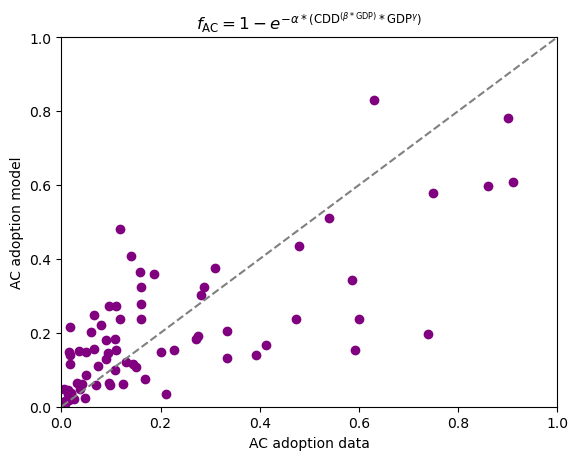

In [10]:
# Fit with new function
popt_comb, pcov_comb = curve_fit(ac_access_combined_exp, xdata, ydata, bounds=(0, np.inf))
print("Fit parameters for AC access combined exponential")
print("alpha = ", popt_comb[0], "beta = ", popt_comb[1], "gamma = ", popt_comb[2], "\n")

# Calculate fit diagnostics
fit_diagnostics(ydata, ac_access_combined_exp(xdata, *popt_comb), popt_comb, pcov_comb, "AC access combined exponential")
# Plot the AC access data vs model
plot_ac_access((ydata), (ac_access_combined_exp(xdata, *popt_comb)), "purple", r"$f_{\mathrm{AC}}=1 - e^{-\alpha * (\mathrm{CDD}^{(\beta*\mathrm{GDP})} * \mathrm{GDP}^{\gamma})}$", 
               "ac_access_combined_exp", log=False)

with open('data/exposure_function_params.pkl', 'wb') as f:
    pickle.dump({'alpha': popt_comb[0], 'beta': popt_comb[1], 'gamma': popt_comb[2]}, f)

Fit parameters for AC access combined exponential log
alpha =  123.03664209104714 beta =  4.14250944781106 gamma =  1.4360678613437208 

Fit diagnostics for  AC access log of combined exponential
R^2:  0.5642756785305165
R^2 step-by-step:  0.5642756785305165
Std. Err:  [69.330341    1.23780401  0.17012262]
t-values [1.77464354 3.34666024 8.44136946]
p-values [0.08012589149640004, 0.0012950744542954418, 2.084554751036194e-12]
AIC:  51.00079925544765


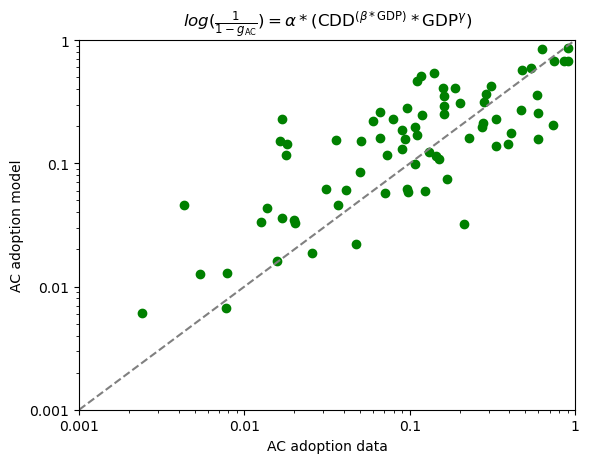

In [11]:
# Repeat the fit with the log of the function

def ac_access_log(xdata, a, b, c):
    cdd, gdp = xdata
    return (a * ((cdd)**(b*gdp) * (gdp)**c))

popt_comb_log, pcov_comb_log = curve_fit(ac_access_log, xdata, np.log(1/(1-ydata)), bounds=(0, np.inf))
print("Fit parameters for AC access combined exponential log")
print("alpha = ", popt_comb_log[0], "beta = ", popt_comb_log[1], "gamma = ", popt_comb_log[2], "\n")

# Calculate fit diagnostics
fit_diagnostics(np.log(1/(1-ydata)), ac_access_log(xdata, *popt_comb_log), popt_comb_log, pcov_comb_log, "AC access log of combined exponential")
# Plot the AC access data vs model
plot_ac_access((ydata), (1.-np.exp(-1*ac_access_log(xdata, *popt_comb_log))), "green", r"$log(\frac{1}{1-g_{\mathrm{AC}}})= \alpha * (\mathrm{CDD}^{(\beta*\mathrm{GDP})} * \mathrm{GDP}^{\gamma})$", "ac_access_combined_exp_log")


With OLS
                            OLS Regression Results                            
Dep. Variable:                     AC   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     55.84
Date:                Fri, 14 Feb 2025   Prob (F-statistic):           1.94e-15
Time:                        14:07:20   Log-Likelihood:                -105.34
No. Observations:                  76   AIC:                             216.7
Df Residuals:                      73   BIC:                             223.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2855      0.651      6.581

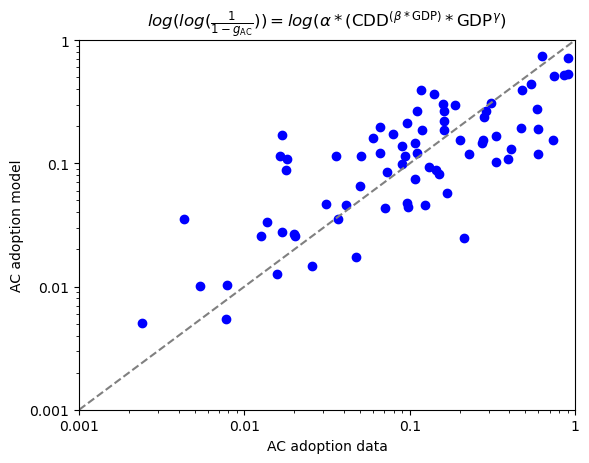

In [12]:
# Repeat the fit with the double log of the function

def ac_access_combined_exp_log_log(xdata, a, b, c):
    return np.log(ac_access_log(xdata, a, b, c))

def ac_access_log_log(xdata, a, b, c):
    return a + b * xdata[1] *np.log(xdata[0]) + c * np.log(xdata[1])

import statsmodels.api as sm
CDD = xdata[0]
GDP = xdata[1]
X = np.column_stack((GDP * np.log(CDD), np.log(GDP)))
X = sm.add_constant(X)  # Adds a column of ones for the intercept term

# Fit the model
model = sm.OLS(np.log(np.log(1/(1-ydata))), X)
results = model.fit()

print("With OLS")
print(results.summary())
pvalues = results.pvalues
formatted_pvalues = ["{:.2e}".format(pval) for pval in pvalues]
print("p-values: ", formatted_pvalues)

popt_comb_log_log, pcov_comb_log_log = curve_fit(ac_access_combined_exp_log_log, xdata, np.log(np.log(1/(1-ydata))), bounds=(0, np.inf))

print("\nFit parameters for AC adoption log log")
print("alpha = ", popt_comb_log_log[0], "beta = ", popt_comb_log_log[1], "gamma = ", popt_comb_log_log[2], "\n")

# Calculate fit diagnostics
fit_diagnostics(np.log(np.log(1/(1-ydata))), ac_access_combined_exp_log_log(xdata, *popt_comb_log_log), popt_comb_log_log, pcov_comb_log_log, "AC access double log of combined exponential")
# Plot the AC access data vs model
plot_ac_access((ydata), (1.-np.exp(-1*ac_access_log(xdata, *popt_comb_log_log))), "blue", r"$log(log(\frac{1}{1-g_{\mathrm{AC}}}))= log(\alpha * (\mathrm{CDD}^{(\beta*\mathrm{GDP})} * \mathrm{GDP}^{\gamma})})))$", "ac_access_combined_exp_log_log")

In [13]:
# Add population data to ac_data

pop_data = read_gdp_data("data/countries/API_SP.POP.TOTL_DS2_en_csv_v2_900.csv", value_name="Population")

# Add population data to the ac_df dataframe for the respective year and country
ac_data = ac_data.merge(pop_data, on=["ISO3", "Year"], how="left")

In [14]:
if config['sensitivity_analysis']['pop_weighted']['value']:
    # Redo the fit with population-weighted data
    popt_comb, pcov_comb = curve_fit(ac_access_combined_exp, xdata, ydata, bounds=(0, np.inf), sigma=1./np.sqrt(ac_data["Population"]))
    print("Fit parameters for AC access combined exponential with population weighting")
    print("alpha = ", popt_comb[0], "beta = ", popt_comb[1], "gamma = ", popt_comb[2], "\n")

    # Calculate fit diagnostics
    fit_diagnostics(ydata, ac_access_combined_exp(xdata, *popt_comb), popt_comb, pcov_comb, "AC access combined exponential")
    # Plot the AC access data vs model
    plot_ac_access((ydata), (ac_access_combined_exp(xdata, *popt_comb)), "purple", r"$f_{\mathrm{AC}}=1 - e^{-\alpha * (\mathrm{CDD}^{(\beta*\mathrm{GDP})} * \mathrm{GDP}^{\gamma})}$", 
                "ac_access_combined_exp", log=False)

    with open('data/exposure_function_params.pkl', 'wb') as f:
        pickle.dump({'alpha': popt_comb[0], 'beta': popt_comb[1], 'gamma': popt_comb[2]}, f)